#### Author: Vamsi Tallam
####  UIN:    432001932


## Task1
Create a dataset class suitable for loading the HW3 dataset files (hw3-letters-test-images-idx3-ubyte,
hw3-letters-test-labels-idx1-ubyte, hw3-letters-train-images-idx3-ubyte, hw3-letters-train-labels-idx1-
ubyte) into your Jupyter notebook on Google colab (colab.research.google.com)

1.   You probably want to mount your Google drive and keep the files there
2.   The label files have a 4 byte integer for the number of items, followed by 1 unsigned byte per label
3.   The image files have a 4 byte integer for the number of images, followed by a 4 byte integer for number of row, followed by a 4 byte integer for number of columns, followed by 1 unsigned byte per pixel (0-255, white -> black)
4.   Create a child class for torch.utils.data.Dataset
5.   NOTE: I have deliberately changed the file format/data files from the MNIST dataset used by
Yann LeCun. You should write your own load method to read the file instead of using a library
that parses the IDX format. 

In [ ]:
# Mount the drive to access data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import random
import tensorflow as tf
import struct as st
import string
import seaborn as sn

from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from __future__ import print_function, division
import keras
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
# To create a child class for torch.utils.data.Dataset'
# As asked built a custom Dataset inspired from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class Extract_Images_Labels(Dataset):
  "To Load Labels and Images"
  Images  = None
  Lablels = None  
  
  def __init__(self, Images_path, Labels_path):
    Images_data = open(Images_path, 'rb')
    Labels_data = open(Labels_path, 'rb')
    
    NImages  = st.unpack('>I',Images_data.read(4))[0]   #number of images
    NRows    = st.unpack('>I',Images_data.read(4))[0]   #number of rows
    NColumns = st.unpack('>I',Images_data.read(4))[0]   #number of column
    NLabels  = st.unpack('>I',Labels_data.read(4))[0]   #number of labels

    NBytes   = NImages*NRows*NColumns*1
    self.Images = np.asarray(st.unpack('>'+'B'*NBytes,Images_data.read(NBytes))).reshape((NImages,NRows,NColumns))
    NBytes   = NLabels*1
    self.Labels = np.asarray(st.unpack('>'+'B'*NBytes,Labels_data.read(NBytes)))

  def __len__(self):
    return len(self.NLabels)

  def __getitem__(self, idx):
    return (self.Images[idx], self.Labels[idx])

In [ ]:
# Path for training images and labels 
Training_data = Extract_Images_Labels('gdrive/MyDrive/Colab Notebooks/CSCE704/hw3-letters-train-images-idx3-ubyte', 'gdrive/MyDrive/Colab Notebooks/CSCE704/hw3-letters-train-labels-idx1-ubyte')

# Assigning Images and corresponding Labels of training data to x_train and y_train 
x_train, y_train = Training_data[:]
 
# Primary checks on loading training data
print(x_train.shape)
print(y_train.shape)


(124800, 28, 28)
(124800,)


In [ ]:
# Path for testing images and labels
Testing_data = Extract_Images_Labels('gdrive/MyDrive/Colab Notebooks/CSCE704/hw3-letters-test-images-idx3-ubyte', 'gdrive/MyDrive/Colab Notebooks/CSCE704/hw3-letters-test-labels-idx1-ubyte')

x_test, y_test = Testing_data[:]

# Primary checks on loading testing data
print(x_test.shape)
print(y_test.shape)

(20800, 28, 28)
(20800,)


End of Task 1

### Task 2
Plot at least 20 of the images using matplotlib.pyplot.imshow (note they may appear rotated 90 degrees
clockwise- that’s OK. If it bothers you transpose the matrix)

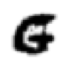

In [ ]:
# plot an image to see if we have loaded correctly
plt.figure(figsize=[1,1])
plt.axis('off')
plt.imshow(x_train[1].T, cmap='gray_r')

In [ ]:
# To generate a random number
r = np.random.RandomState(1234)
randomindex = r.random_integers(0,x_train.shape[0])
randomindex

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 124800 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


92975

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 124800 + 1) instead
  import sys


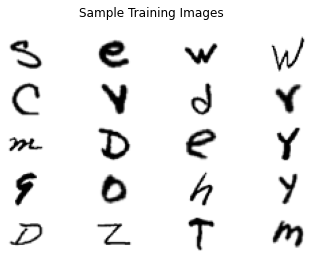

In [ ]:
# Plot a grid of 5X4
r = np.random.RandomState(1234)

for i in range(1, 21):
    plt.subplot(5, 4, i)
    plt.axis('off')
    plt.imshow(x_train[r.random_integers(0,x_train.shape[0])].T, cmap='gray_r') # Used Transpose to rotate the image

plt.suptitle('Sample Training Images');

End of Task 2

### Task 3
Train a convolutional neural network to recognize the 26 letters (note the labels are 1-26 instead of 0-
25).

1.   https://github.com/erykml/medium_articles/blob/master/Computer%20Vision/lenet5_pytorch.
ipynb may be helpful, but that code works on images that are 32x32 (the homework images are
28x28 so you’ll need to create a different architecture)

2.   You should be at least 90% accurate on the validation set. Don’t overtrain your model!

In [ ]:
# Reshape data to be used for training CNN
NRows = x_train.shape[1]
NCols = x_train.shape[2]
input_shape = (NRows, NCols, 1)

x_train = x_train.reshape(x_train.shape[0], NRows, NCols, 1)
x_test  = x_test.reshape(x_test.shape[0], NRows, NCols, 1)

x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

# To see if reshape it done accurately
print(x_train.shape)

(124800, 28, 28, 1)


In [ ]:
# Checking training labels (1 to 26)
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [ ]:
y_train = to_categorical(np.subtract(y_train,1), dtype ="uint8")
print(y_train.shape)

np.unique(y_train)

(124800, 26)


array([0, 1], dtype=uint8)

In [ ]:
def model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=1, activation='LeakyReLU', input_shape = input_shape))  # Input 28 X 28 X 1, Kernelsize (3 X 3), # Filters =32, ouput (28-3+1) X (28-3+1) X 32
    model.add(BatchNormalization()) # Normalization
    model.add(Conv2D(32, (3, 3), activation='LeakyReLU', strides=2)) # Stride = 2 with 32 kernels of size (3 X 3) Reduces map size and tries to learn high level patterns
    model.add(BatchNormalization()) # Normalization
    model.add(Conv2D(64, (3, 3), activation='LeakyReLU', strides=2)) # Stride =2 with 64 kernelsof size (3 X 3) 
    model.add(Dropout(0.4))         # Randomly drop 40% this forces the remaining to learn better
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(26, activation='softmax'))
    return model

In [ ]:
# To test if GPU is available
tf.test.gpu_device_name()

'/device:GPU:0'

Model Training on GPU ( Edit -> NoteBook Settings -> Hardware accelerator -> GPU)

In [ ]:
print(x_train.shape[1:])

SimpleModel = model(x_train.shape[1:])
SimpleModel.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

SimpleModel.summary()

(28, 28, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600) 

In [ ]:
SimpleModel.fit(x_train, y_train, epochs = 10, batch_size = 256)

Epoch 1/10
488/488 [==============================] - 9s 16ms/step - loss: 0.6254 - accuracy: 0.8084
Epoch 2/10
488/488 [==============================] - 8s 16ms/step - loss: 0.2852 - accuracy: 0.9061
Epoch 3/10
488/488 [==============================] - 8s 16ms/step - loss: 0.2392 - accuracy: 0.9197
Epoch 4/10
488/488 [==============================] - 8s 16ms/step - loss: 0.2177 - accuracy: 0.9260
Epoch 5/10
488/488 [==============================] - 8s 16ms/step - loss: 0.2006 - accuracy: 0.9313
Epoch 6/10
488/488 [==============================] - 8s 16ms/step - loss: 0.1903 - accuracy: 0.9335
Epoch 7/10
488/488 [==============================] - 8s 16ms/step - loss: 0.1798 - accuracy: 0.9364
Epoch 8/10
488/488 [==============================] - 8s 16ms/step - loss: 0.1720 - accuracy: 0.9391
Epoch 9/10
488/488 [==============================] - 8s 16ms/step - loss: 0.1660 - accuracy: 0.9404
Epoch 10/10
488/488 [==============================] - 8s 16ms/step - loss: 0.1595 - accura

In [ ]:
y_pred = SimpleModel.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = np.add(y_pred,1)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9333653846153847

### End of Task 3

### Task 4
Compare the time to train the model with and without a hardware accelerator

1.   You can use a comment to indicate the timed output since you can’t easily switch back and forth
in the middle of the code

 **Using CPU** (Edit -> NoteBook Settings -> Hardware accelerator -> **None**)

In [ ]:
# Using CPU
CPUModel = model(x_train.shape[1:])
CPUModel.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
CPUModel.fit(x_train, y_train, epochs = 10, batch_size = 256)

Epoch 1/10
488/488 [==============================] - 148s 301ms/step - loss: 0.6316 - accuracy: 0.8047
Epoch 2/10
488/488 [==============================] - 147s 302ms/step - loss: 0.2876 - accuracy: 0.9049
Epoch 3/10
488/488 [==============================] - 147s 302ms/step - loss: 0.2420 - accuracy: 0.9195
Epoch 4/10
488/488 [==============================] - 148s 304ms/step - loss: 0.2186 - accuracy: 0.9256
Epoch 5/10
488/488 [==============================] - 148s 304ms/step - loss: 0.2029 - accuracy: 0.9299
Epoch 6/10
488/488 [==============================] - 148s 303ms/step - loss: 0.1933 - accuracy: 0.9327
Epoch 7/10
488/488 [==============================] - 148s 303ms/step - loss: 0.1832 - accuracy: 0.9359
Epoch 8/10
488/488 [==============================] - 148s 303ms/step - loss: 0.1759 - accuracy: 0.9374
Epoch 9/10
488/488 [==============================] - 148s 303ms/step - loss: 0.1687 - accuracy: 0.9403
Epoch 10/10
488/488 [==============================] - 148s 303m

Using CPU each Epoch takes **148s** while using GPU each Epoch takes only **8s**

In [ ]:
CPUModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [ ]:
# Using CPU
y_pred_CPU = CPUModel.predict(x_test)
y_pred_CPU = np.argmax(y_pred_CPU, axis=1)
y_pred_CPU = np.add(y_pred_CPU,1)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_CPU)

0.9345192307692308

### End of Task 4

### Task 5
Output a confusion matrix of the test set with model.

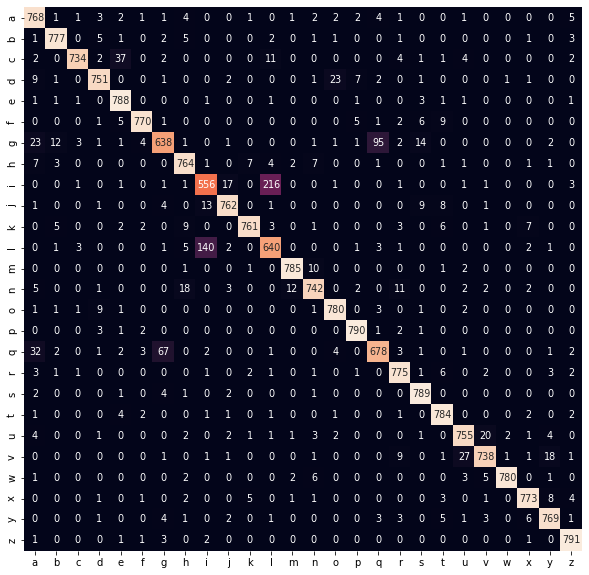

In [ ]:
# Confusion Matrix
con_mat = confusion_matrix(y_test,y_pred_CPU)
con_mat_df = pd.DataFrame(con_mat,list(string.ascii_lowercase),list(string.ascii_lowercase)) 
plt.figure(figsize = (10,10))
plt.ylabel('True label')
plt.xlabel('Predicted label')
sn.set(font_scale=0.8)
sn.heatmap(con_mat_df, annot = True, fmt='g', cbar=False)

**Observations:** The following pairs were misclassfied more frequently

1.   i and l
2.   q and g
3.   d and o
4.   a and q and a and g
5.   h and n




### End of Task 5